In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/initialization')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations/fc_abc.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import torch
import pickle
from utils.tools import load_pickle

from utils.tools import read_yaml, set_random_seeds
from utils.plot.abc_parameterizations.initializations import *
from utils.plot.abc_parameterizations.one_d_functions import *
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected import ntk, ip, muP, ipllr
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP

## Set variables

In [5]:
SEED = 42
N_SAMPLES = 100
N_TRAIN = 10
BASE_LR = 1.0

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)
base_config = ModelConfig(config_dict)

# modify config for this notebook
base_config.architecture['input_size'] = 1
base_config.architecture['output_size'] = 1
base_config.architecture['bias'] = False
base_config.activation.name = 'relu'
base_config.loss.name = 'mse'
base_config.optimizer.params['lr'] = BASE_LR

In [6]:
xs, ys = generate_1d_data(n_samples=10)

## Define models

In [7]:
WIDTHS = [20, 50, 128, 256, 512, 1024, 1400]
N_WARMUP_STEPS = 1
L = 4
N_TRIALS = 5

In [8]:
name_to_model_dict = {
    'StandardIP': StandardFCIP,
    'NTK': ntk.FCNTK,
    'muP': muP.FCmuP,
    'IPLLR': ipllr.FcIPLLR
}

In [9]:
models_dict = dict()
for name, model in name_to_model_dict.items():
    models_dict[name] = dict()
    for width in WIDTHS:  # define models with different widths
        # first modify the base common config
        config = deepcopy(base_config)
        config.name = name
        config.architecture['width'] = width
        config.architecture['n_layers'] = L + 1
        
        if name == 'IPLLR':
            scheduler_config = {'name': 'warmup_switch', 
                                'params': {'n_warmup_steps': N_WARMUP_STEPS}}
            config.scheduler = BaseConfig(scheduler_config)
        
        # define N_TRIALS random initializations of the same model
        models_dict[name][width] = [name_to_model_dict[name](config) for _ in range(N_TRIALS)]

In [10]:
batch_xs = torch.unsqueeze(xs, 1)
batch_ys = torch.unsqueeze(ys, 1)
for name in models_dict.keys():
    for width in WIDTHS:
        for model in models_dict[name][width]:
            fit_model(model, batch_xs, batch_ys, n_epochs=1)

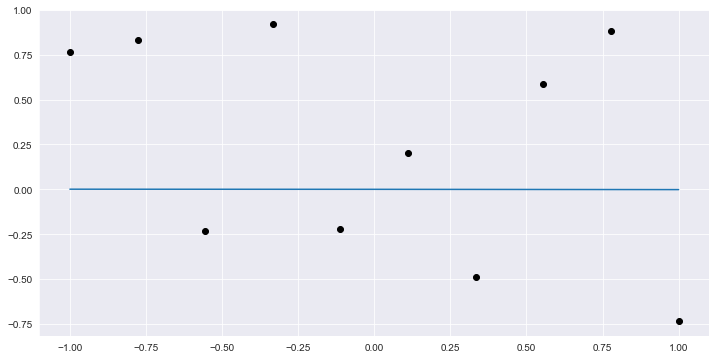

In [11]:
name = 'StandardIP'
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][20][0], xs, ys, label=name, scatter=True)

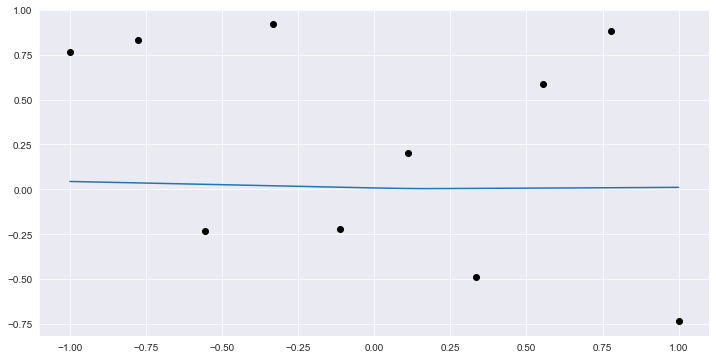

In [12]:
name = 'IPLLR'
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][20][0], xs, ys, label=name, scatter=True)

In [13]:
for name in models_dict.keys():
    for width in models_dict[name].keys():
        for model in models_dict[name][width]:
            if model.base_lr != BASE_LR:
                print(name, width, model.base_lr)

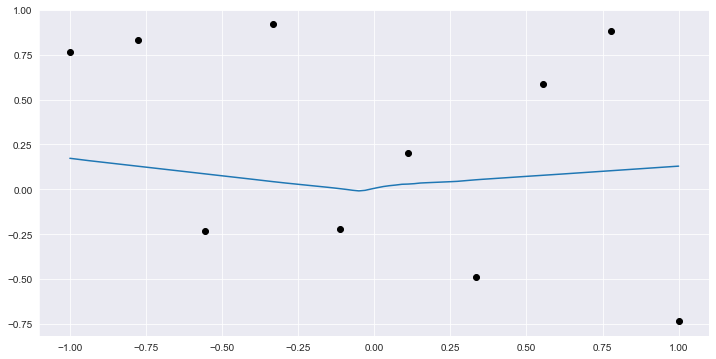

In [14]:
name = 'muP'

plt.figure(figsize=(12, 6))
plot_model(models_dict[name][20][0], xs, ys, label=name, scatter=True)

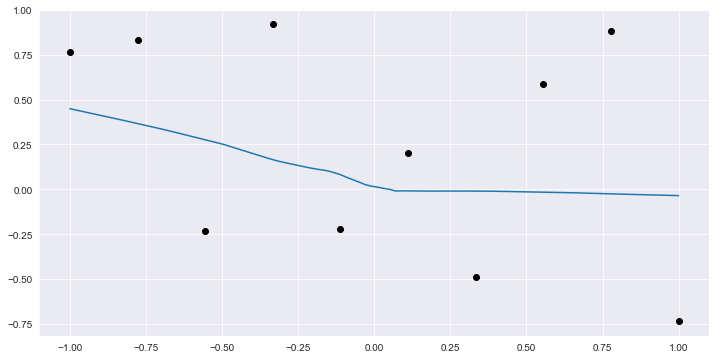

In [15]:
name = 'NTK'
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][20][0], xs, ys, label=name, scatter=True)

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


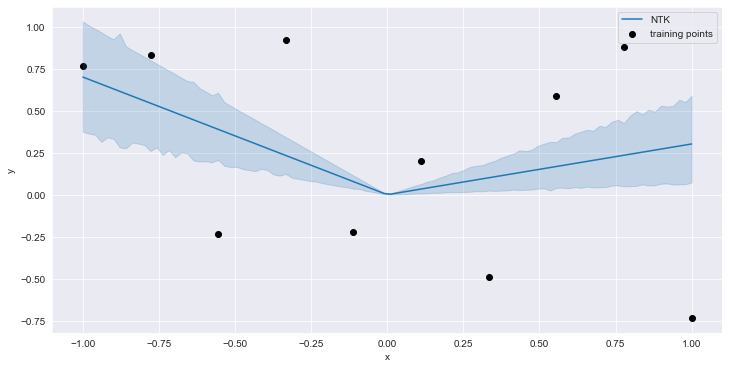

In [16]:
name = 'NTK'
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][20], xs, ys, label=name, scatter=True)

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


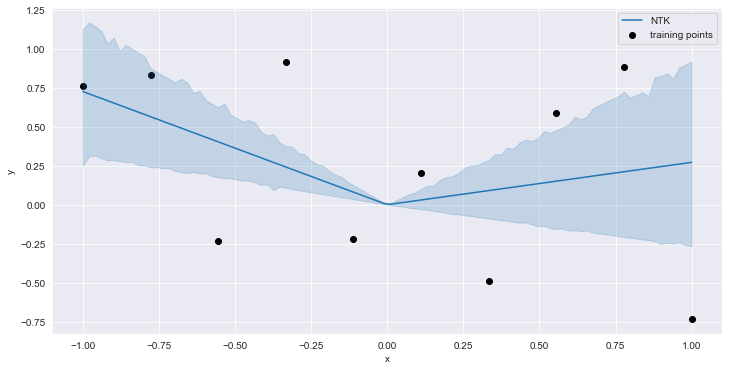

In [17]:
name = 'NTK'
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][256], xs, ys, label=name, scatter=True)

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


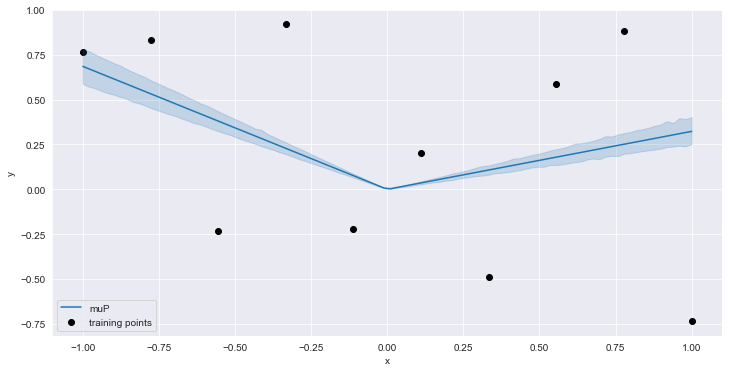

In [18]:
name = 'muP'
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][256], xs, ys, label=name, scatter=True)

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


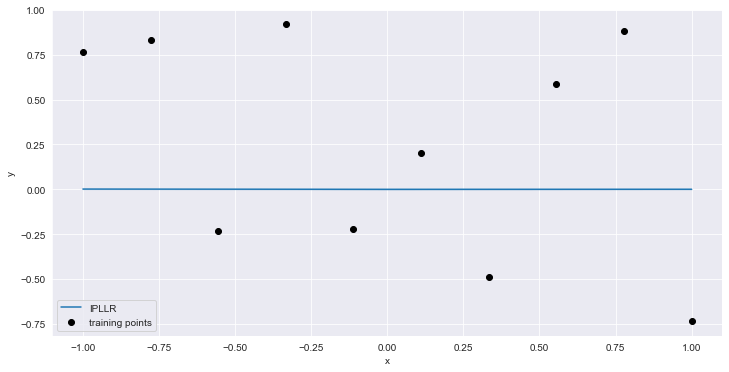

In [19]:
name = 'IPLLR'
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][256], xs, ys, label=name, scatter=True)

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


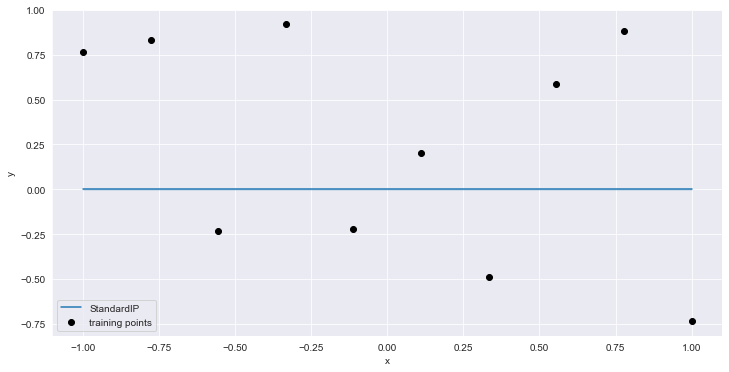

In [20]:
name = 'StandardIP'
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][256], xs, ys, label=name, scatter=True)

In [21]:
df = pd.DataFrame(columns=['x', 'y', 'z'], 
                  data=[[1, 2, 3],
                        [4, 5, 6],
                        [1, 3.5, 1.1],
                        [2, 4.1, -0.5],
                        [2, 1.2, -4.1]])
df.head()

,x,y,z
0,1,2.0,3.0
1,4,5.0,6.0
2,1,3.5,1.1
3,2,4.1,-0.5
4,2,1.2,-4.1


In [22]:
df.groupby(by='x').mean()

,y,z
x,,
1,2.75,2.05
2,2.65,-2.30
4,5.00,6.00


In [23]:
gp = df.groupby(by='x')
gp

In [24]:
gp.mean()

,y,z
x,,
1,2.75,2.05
2,2.65,-2.30
4,5.00,6.00
